# Ноутбук для соревнования в Kaggle. Анализ датасета "Titanic"

## Загружаем данные и библиотеки

In [1]:
import pandas as pd #Библиотека для реализации анализа панельных данных
import numpy as np #Библиотека для реализации вычислительных операций на многомерных массивах
import matplotlib.pyplot as plt #Для построения графиков
import seaborn as sns #Статистическая визуализация
%matplotlib inline #Отображение визуализации в ноутбуке

UsageError: unrecognized arguments: #Отображение визуализации в ноутбуке


In [2]:
#Для логистической регрессии
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel 
#Для случайного леса
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV #Кроссвалидация методом случайного поиска. Простой, быстрый метод подобрать подходящие гиперпараметры для модели.

In [9]:
#Загружаем датасет 
train = pd.read_csv('train.csv') #Обучающая выборка
test = pd.read_csv('test.csv') #Тестовая выборкка

## Переработка данных обучающей выборки


In [10]:
train.head(10) #Оценим вид таблицы. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


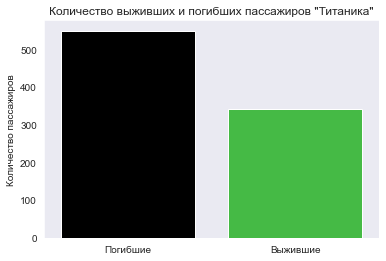

In [138]:
#Нам интересно посмотреть наглядно, сколько выживших и погибших.
SURV1 = sns.countplot(x = 'Survived', data = train, palette=["#000000", "#32cd32"])
SURV1.set(xlabel='')
SURV1.set(ylabel='Количество пассажиров')
SURV1.set(title = 'Количество выживших и погибших пассажиров "Титаника"')
fate = ['Погибшие', 'Выжившие']
SURV1.set_xticklabels(fate)
sns.set_style('dark')

Большинству пассажиров не позавидуешь. Рассмотрим возможные факторы, повлиявшие на их судьбу

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

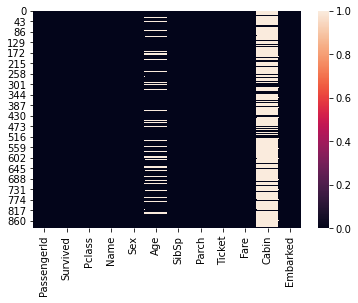

In [19]:
#Ещё в начале таблицы были обнаружены пустые значения - посмотрим, сколько их всего.
sns.heatmap(train.isnull())
train.isnull().sum()
#Пропуски в номерах кают можно игнорировать, но возраст и место посадки могут повлиять на результат.

In [20]:
#Разобъем обучающую выборку на подвыборки для анализа средних возрастов по каждому классу.
class_1 = train['Pclass'] == 1
class_2 = train['Pclass'] == 2
class_3 = train['Pclass'] == 3
t1 = train[class_1]
t2 = train[class_2]
t3 = train[class_3]

In [21]:
#Заменим пропущенные значения возраста средними значениями по классам. 
def fill_age(cols):
    Age = cols[1]
    Pclass = cols[0]
    if pd.isnull(Age):
        if Pclass == 1:
            return t1['Age'].mean()
        elif Pclass == 2:
            return t2['Age'].mean()
        else: 
            return t3['Age'].mean()
        
    else: 
        return Age

In [22]:
train['Age'] = train[['Pclass', 'Age']].apply(fill_age, axis = 1)
train.drop('Cabin', axis = 1, inplace = True)


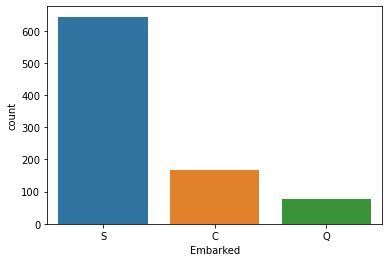

In [23]:
#Наглядно определим самый популярный пункт отправления и заполним недостающие значения в датасете.
sns.countplot(x = 'Embarked', data = train)
train['Embarked'] = train['Embarked'].fillna("S")

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

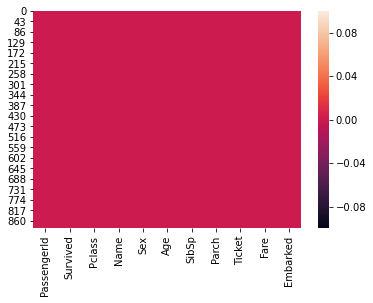

In [26]:
#Проверим ещё раз.
sns.heatmap(train.isnull())
train.isnull().sum()

In [27]:
#Преобразуем качественные характеристики в фиктивные переменные. Так мы сможем квантифицировать категориальные признаки наших данных.
sex = pd.get_dummies(train['Sex'], drop_first = True)
embarked = pd.get_dummies(train['Embarked'], drop_first = True)
train = pd.concat([train, sex, embarked], axis = 1)
train.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


[Text(0.5, 1.0, 'Распределение выживших и погибших по классам')]

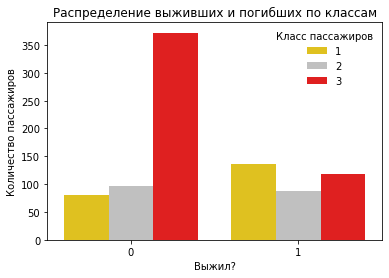

In [44]:
SURV_CLASS = sns.countplot(x = 'Survived', hue = 'Pclass', data = train, palette=["#ffd700", "#c0c0c0", "#ff0000"])
SURV_CLASS.set(xlabel='Выжил?')
SURV_CLASS.set(ylabel='Количество пассажиров')
SURV_CLASS.legend(title='Класс пассажиров', frameon=False)
SURV_CLASS.set(title = 'Распределение выживших и погибших по классам')
#Выживает большая часть первого класса. Примерно половина второго класса так же спасается. Больше половины третьего класса погибли.

In [52]:
#Отделяем зависимую переменную от объясняющих
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']

## Переработка данных тестовой выборки

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

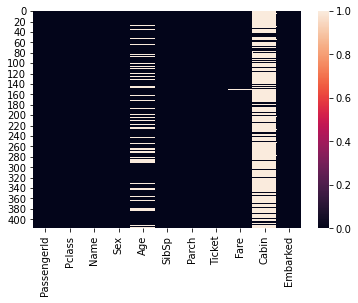

In [53]:
#Необходимо проделать аналогичную операцию на тестовой выборке.
sns.heatmap(test.isnull())
test.isnull().sum()

In [54]:
#Повторим все преобразования на тестовой выборке
test_class_1 = test['Pclass'] == 1
test_class_2 = test['Pclass'] == 2
test_class_3 = test['Pclass'] == 3
t1 = test[class_1]
t2 = test[class_2]
t3 = test[class_3]

C:\Users\nkhom\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\nkhom\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\nkhom\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [55]:
test['Age'] = test[['Pclass', 'Age']].apply(fill_age, axis = 1)
test.drop('Cabin', axis = 1, inplace = True)


In [56]:
test.isnull().sum()
test['Fare'] = test[['Pclass', 'Fare']].apply(fill_age, axis = 1)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

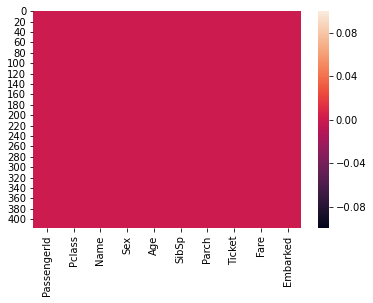

In [57]:
sns.heatmap(test.isnull())
test.isnull().sum()

In [58]:
#Снова получаем фиктивные переменнные.
sex1 = pd.get_dummies(test['Sex'], drop_first = True)
embarked1 = pd.get_dummies(test['Embarked'], drop_first = True)
test = pd.concat([test, sex1, embarked1], axis = 1)
test.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
test.head(10)

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1
5,3,14.0,0,0,9.2250,1,0,1
6,3,30.0,0,0,7.6292,0,1,0
7,2,26.0,1,1,29.0000,1,0,1
8,3,18.0,0,0,7.2292,0,0,0
9,3,21.0,2,0,24.1500,1,0,1


In [59]:
#Матрица переменных в тестовой выборке
X_test = test
X_text.head()

NameError: name 'X_text' is not defined

In [60]:
#Обучаем модель логистической регрессии с регуляризацией l2 во избежание переобучения
Logreg = LogisticRegression(C = 1.0, penalty = 'l2')
Logreg.fit(X_train, y_train)

C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
#Применяем модель на тестовой выборке
y_test = Logreg.predict(test)
y_test

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [62]:
#Подытожим результаты:
survived = pd.Series(y_test)
test_summary = pd.read_csv('test.csv')

In [63]:
test_summary = pd.concat([test_summary, survived], axis = 1)
test_summary.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Age', 'Pclass', 'Parch', 'Fare', 'SibSp', 'Cabin'], axis = 1, inplace = True)

In [64]:
test_summary.columns = ['PassengerId', 'Survived']
test_summary

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


[Text(0, 0, 'Погибшие'), Text(0, 0, 'Выжившие')]

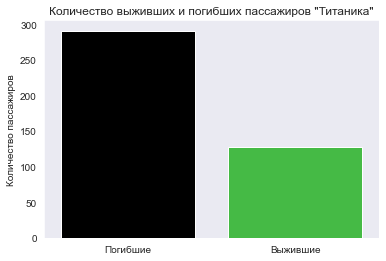

In [137]:
#Посмотрим, сколько выживших предсказала первоначальная модель.
SURV2 = sns.countplot(x = 'Survived', data = test_summary, palette=["#000000", "#32cd32"])
SURV2.set(xlabel='')
SURV2.set(ylabel='Количество пассажиров')
sns.set_style('dark')
SURV2.set(title = 'Количество выживших и погибших пассажиров "Титаника"')
SURV2.set_xticklabels(fate)

## Попробуем улучшить модель с помощью случайного леса

Переходим к кросс-валидации методом рандомизированного поиска

In [66]:
class_weight= [None, 'balanced']  #Нужно ли взвешивать значения переменных по классам?
intercept_scaling = [int(x) for x in np.linspace(start = 0, stop = 100, num = 100)] 
max_iter= [int(x) for x in np.linspace(start = 0, stop = 1000, num = 100)] #Максимальное количество итераций
penalty = ['l1', 'l2'] #Выбрать метод регуляризации во избежания переобучения модели. LASSO или Ridge?
warm_start= [True, False]
param_dist = { 'class_weight': class_weight,
               'intercept_scaling': intercept_scaling,
               'penalty': penalty,
               'max_iter': max_iter,
               'warm_start': warm_start}
log_Train = LogisticRegression()
log_cv = RandomizedSearchCV(log_Train, param_dist, cv = 5)
CV_LOG = log_cv.fit(X_train, y_train)

C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [67]:
CV_LOG.best_params_

{'warm_start': False,
 'penalty': 'l2',
 'max_iter': 575,
 'intercept_scaling': 65,
 'class_weight': None}

In [68]:
#Приводим модель логистической регрессии к подходящему виду
Logreg1 = SelectFromModel(LogisticRegression(C = 1.0, warm_start = False, max_iter = 686, intercept_scaling = 84, penalty = 'l1', class_weight = None))
Logreg1.fit(X_train, y_train)

C:\Users\nkhom\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=84,
                                             l1_ratio=None, max_iter=686,
                                             multi_class='warn', n_jobs=None,
                                             penalty='l1', random_state=None,
                                             solver='warn', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [71]:
#Преобразуем данные о признаках на основе модели логистической регрессии.
X_train_1 = Logreg1.transform(X_train)
X_test_1 = Logreg1.transform(X_test)

## Кросс-валидация параметров случайного леса 
Мы можем так же вычислить оптимальные значения для гиперпараметров нашей модели случайного леса с помощью кросс-валидации.

In [122]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 30)] #Количество деревьев
max_features = ['log2', 'sqrt'] #Максимальное количество параметров расщепления 
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)] #Глубина древа
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)] #Минимальное количество расщеплений
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)] #Минимальное количество объектов на листе
bootstrap = [True, False] #Бутстрэп: генерировать для обучения выборки методом Монте-Карло? Если нет, то используется вся совокупность
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc_Train = RandomForestClassifier()
rfc_cv = RandomizedSearchCV(rfc_Train, param_dist, cv = 7)
CV_RFC = rfc_cv.fit(X_train_1, y_train)

Wall time: 33.9 s


Около двадцати секунд... Относительно долго.

In [123]:
#Определим лучшие параметры для нашей модели
CV_RFC.best_params_


{'n_estimators': 782,
 'min_samples_split': 7,
 'min_samples_leaf': 12,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}

In [115]:
#Точность кросс-валидации
CV_RFC.best_score_

0.8181818181818182

## Модель случайного леса

In [124]:
#Обучаем модель случайного леса по полученным параметрам кросс-валидации
rfc = RandomForestClassifier(n_estimators = 782, min_samples_split = 7, min_samples_leaf = 12, max_features = 'sqrt', max_depth = 5, bootstrap = False)
rfc = rfc.fit(X_train_1, y_train)


In [125]:
#Используем модель для предсказания судьбы пассажиров тестовой выборки
y_test_1 = rfc.predict(X_test_1)
y_test_1

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [126]:
survived_1 = pd.Series(y_test_1)
test_summary_1 = pd.read_csv('test.csv')

In [127]:
test_summary = pd.concat([test_summary_1, survived_1], axis = 1)
test_summary.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Age', 'Pclass', 'Parch', 'Fare', 'SibSp', 'Cabin'], axis = 1, inplace = True)

In [128]:
#Оформляем итоговый датасет с прогнозами на каждого пассажира тестовой выборки
test_summary.columns = ['PassengerId', 'Survived']
test_summary

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


[Text(0, 0, 'Погибшие'), Text(0, 0, 'Выжившие')]

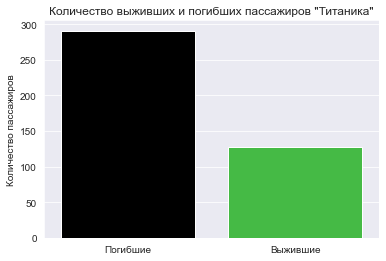

In [136]:
#Напоследок выясним, оптимистичен ли этот прогноз относительно прогноза методом простой логистической регрессии.
SURV3 = sns.countplot(x = 'Survived', data = test_summary, palette=["#000000", "#32cd32"])
SURV3.set(xlabel='')
sns.set_style('dark')
SURV3.set(ylabel='Количество пассажиров')
SURV3.set(title = 'Количество выживших и погибших пассажиров "Титаника"')
SURV3.set_xticklabels(fate)

Прогноз не стал более или менее "оптимистичным" - более вероятно, что изменились ошибки первого и второго рода, и ряд неправильно определённых смертей и выживаний были возвращены на свои места.


In [ ]:
test_summary.to_csv(r'D:\Titanic\test_final_NKhomrach.csv', index = False) #Сохраняем результаты

### Вот и всё! Ссылка на мою страницу в Kaggle - https://www.kaggle.com/nikitakhomrach/competitions